# Non Temporal CNN approach

In [20]:
# Import required libraries
import pandas as pd
import src.dataPreparation as prep
import numpy as np
import tensorflow as tf
import tests.timeseriestesting as tst
import wandb

wandb.login()

True

In [21]:
# Import data
ibm = pd.read_csv('../data/ibm_historical.csv')
msft = pd.read_csv('../data/msft_historical.csv')
nvda = pd.read_csv('../data/nvda_historical.csv')

# Drop Date column
ibm.drop(columns=['Date'], inplace=True)
msft.drop(columns=['Date'], inplace=True)
nvda.drop(columns=['Date'], inplace=True)

# Data cleaning steps
prep.dataCleaning(ibm)
prep.dataCleaning(msft)
prep.dataCleaning(nvda)

# Create target variables
ibm = prep.calculateTarget(ibm)
msft = prep.calculateTarget(msft)
nvda = prep.calculateTarget(nvda)

# Create train and test sets
ibm_train, ibm_test = ibm[:-858], ibm[-858:]
msft_train, msft_test = msft[:-858], msft[-858:]
nvda_train, nvda_test = nvda[:-858], nvda[-858:]


In [22]:
# Transform for modelling
window = 5

ibm_train_X, ibm_train_y = prep.nonTemporalTransform(
    ibm_train.drop(columns=['target']),
    ibm_train['target'],
    window_size=window
)

msft_train_X, msft_train_y = prep.nonTemporalTransform(
    msft_train.drop(columns=['target']),
    msft_train['target'],
    window_size=window
)

nvda_train_X, nvda_train_y = prep.nonTemporalTransform(
    nvda_train.drop(columns=['target']),
    nvda_train['target'],
    window_size=window
)

# Shuffle training tensors
ibm_train_X, ibm_train_y = prep.shuffle_tensors(ibm_train_X, ibm_train_y)
msft_train_X, msft_train_y = prep.shuffle_tensors(msft_train_X, msft_train_y)
nvda_train_X, nvda_train_y = prep.shuffle_tensors(nvda_train_X, nvda_train_y)


In [23]:
# Create validation tests
ibm_train_X, ibm_val_X, ibm_train_y, ibm_val_y = ibm_train_X[:-858], ibm_train_X[-858:], ibm_train_y[:-858], ibm_train_y[-858:]
msft_train_X, msft_val_X, msft_train_y, msft_val_y = msft_train_X[:-858], msft_train_X[-858:], msft_train_y[:-858], msft_train_y[-858:]
nvda_train_X, nvda_val_X, nvda_train_y, nvda_val_y = nvda_train_X[:-858], nvda_train_X[-858:], nvda_train_y[:-858], nvda_train_y[-858:]

# TODO Clean test data
ibm_test_X, ibm_test_y = prep.nonTemporalTransform(
    ibm_test.drop(columns=['target']),
    ibm_test['target'],
    window_size=window
)

msft_test_X, msft_test_y = prep.nonTemporalTransform(
    msft_test.drop(columns=['target']),
    msft_test['target'],
    window_size=window
)

nvda_test_X, nvda_test_y = prep.nonTemporalTransform(
    nvda_test.drop(columns=['target']),
    nvda_test['target'],
    window_size=window
)

In [24]:
wandb.init(project="Trading-system",
           config={
               "batch_size": 32,
               "learning_rate": 0.001,
               "dataset": "IBM_daily",
           })

In [25]:
%%wandb

# 1. Create the model
model_1 = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv1D(8, kernel_size=(1), activation='relu'),
        tf.keras.layers.Conv1D(8, kernel_size=(1), activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=(1)),
        tf.keras.layers.Conv1D(8, kernel_size=(1), activation='relu'),
        tf.keras.layers.MaxPool1D(pool_size=(1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

# 2. Compile the model
model_1.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# 3. Fit the model
history = model_1.fit(
    ibm_train_X, tf.cast(ibm_train_y, dtype=tf.int32),
    epochs=100,
    callbacks=[wandb.keras.WandbCallback()]
)

# 4. Evaluate the model with the validation set
model_1.evaluate(ibm_val_X, ibm_val_y)

wandb.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING Unable to compute FLOPs for this model.


Epoch 1/100


2022-11-12 10:52:56.112120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 2s 12ms/step - loss: 112521.8281 - accuracy: 0.5031
Epoch 2/100
126/126 [==============================] - 1s 10ms/step - loss: 26816.9453 - accuracy: 0.5074
Epoch 3/100
126/126 [==============================] - 1s 10ms/step - loss: 6604.8535 - accuracy: 0.4921
Epoch 4/100
126/126 [==============================] - 1s 9ms/step - loss: 0.6934 - accuracy: 0.4792
Epoch 5/100
126/126 [==============================] - 1s 10ms/step - loss: 0.6930 - accuracy: 0.5194
Epoch 6/100
126/126 [==============================] - 1s 9ms/step - loss: 0.6928 - accuracy: 0.5208
Epoch 7/100
126/126 [==============================] - 1s 9ms/step - loss: 0.6926 - accuracy: 0.5208
Epoch 8/100
126/126 [==============================] - 1s 9ms/step - loss: 0.6925 - accuracy: 0.5208
Epoch 9/100
126/126 [==============================] - 1s 9ms/step - loss: 0.6924 - accuracy: 0.5208
Epoch 10/100
126/126 [==============================] - 1s 9ms/step - loss: 0.6924 - ac

2022-11-12 10:54:47.603958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 0s 7ms/step - loss: 0.6933 - accuracy: 0.5082


accuracy,▄▁██████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.52085
epoch,99
loss,0.69231


0it [00:00, ?it/s]2022-11-12 10:54:54.390710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
853it [00:21, 39.60it/s]


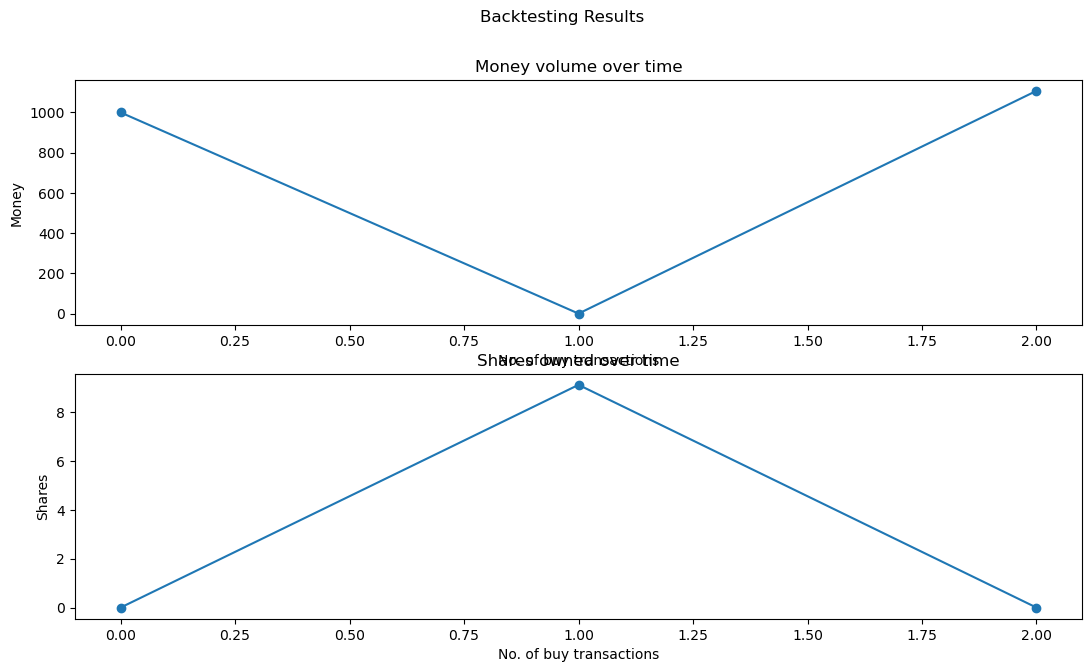

In [26]:
# Define assets
assets = tst.Assets(money=1000)

# Run testing run
predictions = tst.testing_run(assets=assets, model=model_1, test_data=ibm_test_X)

# Plot testing results
tst.plot_testing_run(assets)

In [27]:
assets.get_history()

([1000, 0, 1107.1994191687193], [0, 9.112002301895993, 0])

In [28]:
predictions[:10], predictions[-10:]

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [29]:
sum(ibm_train_y)/ibm_train_y.shape[0], sum(ibm_val_y)/ibm_val_y.shape[0]

(<tf.Tensor: shape=(), dtype=float64, numpy=0.5208489388264669>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.5081585081585082>)

### Notes
`Model_1` is not great. It has poor accuracy results over both the train and validation sets. Looking at this further the models predictions are only the positive class.

There are two directions this could now take. Change of neural architecture and change of data treatment.

`Model_2` will transform the data inside along the first axis. The plan is to normalize the following columns so that they are between 0 and 1.
* Open
* High
* Low
* Close
* Volume

The first four will be normalized together and Volume will be normalized by itself to prevent the distribution of values being bimodal.

TensorShape([858, 5, 5])